<a href="https://colab.research.google.com/github/nevalenaginda/Cassava-Disease-Identification/blob/master/MobilNetV2_Cassava_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow
tensorflow.__version__

'2.3.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
#%cd -
%cd drive/My Drive/Data Singkong
!ls

/content/drive/My Drive/Data Singkong
'Model Oca'  'My Model'   test	 train


**Mengecek Ketersedian GPU**

In [6]:
import tensorflow
tensorflow.test.gpu_device_name()

'/device:GPU:0'

**Memuat Library**

In [7]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import tensorflow.python.keras as keras

**Memuat Nama File**

In [8]:
base_path = 'train/'
categories = ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']
fnames = []
for category in categories:
    cassava_folder = os.path.join(base_path, category)
    file_names = os.listdir(cassava_folder)
    full_path = [os.path.join(cassava_folder, file_name) for file_name in file_names]
    fnames.append(full_path)
print('length for each category:', [len(f) for f in fnames])

length for each category: [419, 483, 405, 493, 288]


**Memuat Dataset Gambar**

In [9]:
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)
print('number of images for each category:', [len(f) for f in images])

number of images for each category: [419, 483, 405, 493, 288]


**Melihat Ukuran Gambar Minimal Dataset Pada Masing-Masing Kategori Penyakit**

In [10]:
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))

500,424 is the min shape for cbb
500,500 is the min shape for cbsd
500,500 is the min shape for cgm
500,499 is the min shape for cmd
347,464 is the min shape for healthy


**Membuat Fungsi Untuk Konversi Gambar Format BGR ke RGB**

In [11]:
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

**Menampilkan Sebuah Contoh Gambar Pada Masing-Masing Kategori Penyakit**

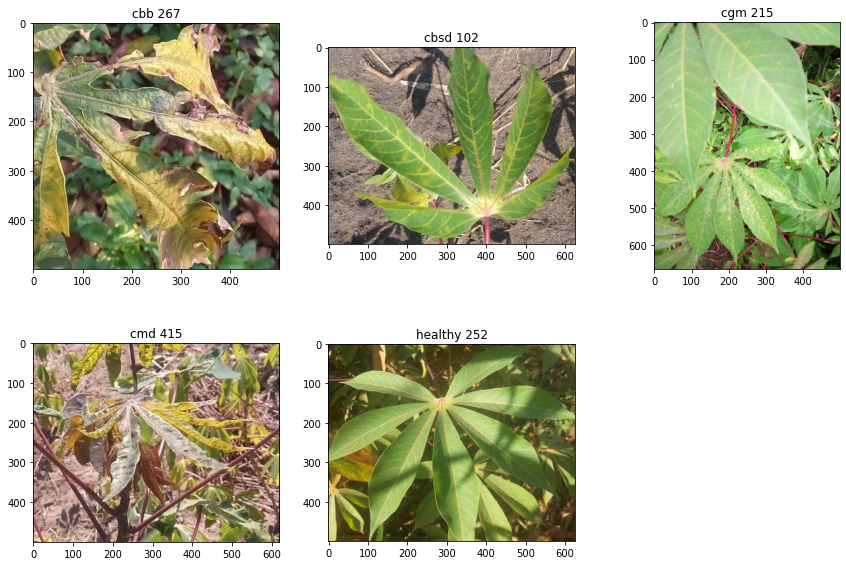

In [12]:
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(2,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cvtRGB(imgs[idx]))
    plt.grid(False)
    plt.title(categories[i]+' '+str(idx))
plt.show()

**Mengubah Ukuran Gambar Dataset ke Ukuran 224x224**

(666, 500, 3)
(224, 224, 3)


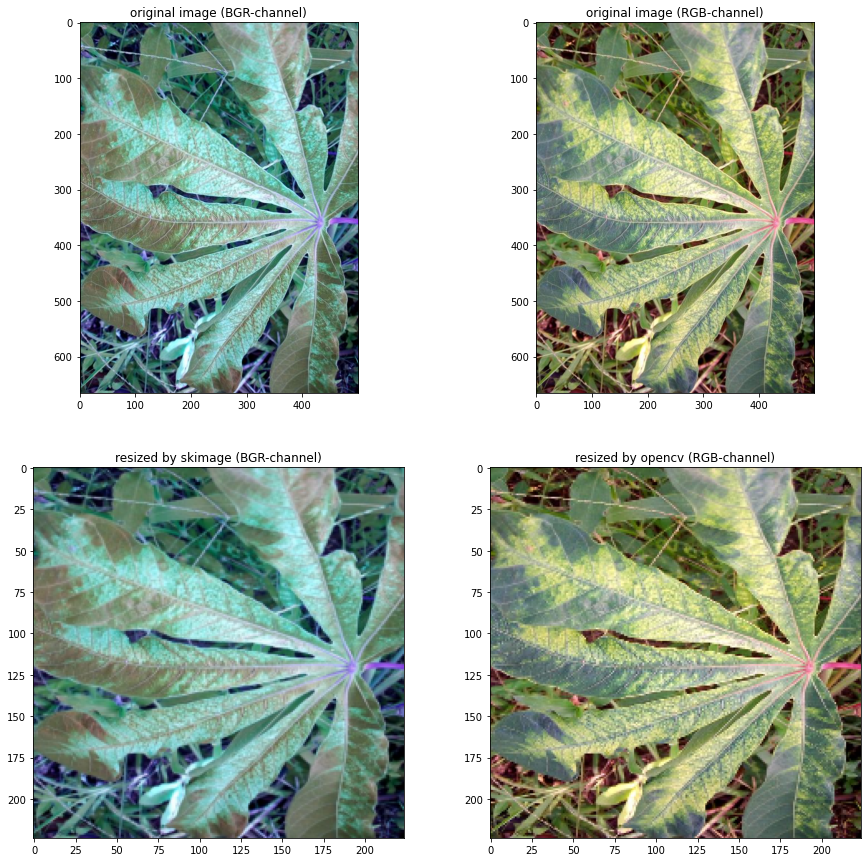

In [13]:
img_width, img_height = 224, 224

img = images[3][100]
print(img.shape)
resized_img = resize(img, (img_width, img_height, 3))
resized_img2 = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)
print(resized_img.shape)
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('original image (BGR-channel)')
plt.grid(False)
plt.imshow(img)
plt.subplot(2,2,2)
plt.title('original image (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(img))
plt.subplot(2,2,3)
plt.title('resized by skimage (BGR-channel)')
plt.grid(False)
plt.imshow((resized_img))
plt.subplot(2,2,4)
plt.title('resized by opencv (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(resized_img2))
plt.show()

In [14]:
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

**Membagi Dataset Menjadi 75% Data Latih dan 25% Data Validasi**

In [15]:
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.75, test_size=0.25)
    train_images.append(train)
    val_images.append(test)

**Membuat Label**

In [16]:
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val_images:', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

[314, 362, 303, 369, 216]
sum of train images: 1564
[105, 121, 102, 124, 72]
sum of val_images: 524


**Mengkonversi Data Gambar Ke Dalam Bentuk Array Numpy**

In [17]:
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

In [18]:
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)

train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
#train_labels = tensorflow.keras.utils.to_categorical(train_categories, len(categories))
#val_labels = tensorflow.keras.utils.to_categorical(val_categories, len(categories))
train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))
print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)

Before converting
train data: (1564, 224, 224, 3)
train labels: (1564,)

After converting
train data: (1564, 224, 224, 3)
train labels: (1564, 5)


**Mengacak Dataset (Mengatur Seed dan Randomize Data Latih dan Validasi)**

In [19]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

In [20]:
train_data = train_data[:len(train_data)]
train_labels = train_labels[:len(train_data)]
val_data = val_data[:len(val_data)]
val_labels = val_labels[:len(val_data)]
print('shape of train data:', train_data.shape)
print('shape of train labels:', train_labels.shape)
print('shape of val data:', val_data.shape)
print('shape of val labels:', val_labels.shape)

shape of train data: (1564, 224, 224, 3)
shape of train labels: (1564, 5)
shape of val data: (524, 224, 224, 3)
shape of val labels: (524, 5)


**Membuat Model Transfer Learning**

In [21]:
def create_mode_mobilenet():
  # Membuat model dasar (base model) dari pre-trained model MobileNet
  base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224,3),
                                              include_top=False, 
                                              weights='imagenet')
  base_model.trainable = False
  model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GaussianNoise(0.25),  
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
  ])
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=0.0005), metrics=['acc'])
  return model

In [22]:
mobile_net = create_mode_mobilenet()
mobile_net.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
gaussian_noise (GaussianNois (None, 7, 7, 1280)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


**Membuat Generator**

In [23]:
batch_size = 32
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=8,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    vertical_flip=False,
    channel_shift_range = 0.1,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],
)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(
    rescale=1./255
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)

**Membuat Callbacks**

In [24]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, 
                                                                    patience=6, verbose=2, mode='auto',
                                                                    min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=6, verbose=10, mode='auto',
                                             baseline=None, restore_best_weights=True)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint("My Model/best_model.h5", monitor='val_acc', mode='max', verbose=2, save_best_only=True)

**Melatih Model**

In [25]:
start = time.time()
EPOCHS= 300
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size + 1
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size + 1
mobile_net_info = mobile_net.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    verbose=2,
                    callbacks=[reduce_lr, early_stop, model_checkpoint])
                    #initial_epoch = 10)
end = time.time()
duration = end - start
print ('\n Model took %0.2f seconds (%0.1f minutes) to train'%(duration, duration/60) )

Epoch 1/300

Epoch 00001: val_acc improved from -inf to 0.41603, saving model to My Model/best_model.h5
49/49 - 26s - loss: 1.5138 - acc: 0.3645 - val_loss: 1.3509 - val_acc: 0.4160
Epoch 2/300

Epoch 00002: val_acc improved from 0.41603 to 0.50382, saving model to My Model/best_model.h5
49/49 - 24s - loss: 1.2749 - acc: 0.4719 - val_loss: 1.2023 - val_acc: 0.5038
Epoch 3/300

Epoch 00003: val_acc improved from 0.50382 to 0.55534, saving model to My Model/best_model.h5
49/49 - 25s - loss: 1.1585 - acc: 0.5262 - val_loss: 1.1283 - val_acc: 0.5553
Epoch 4/300

Epoch 00004: val_acc improved from 0.55534 to 0.56107, saving model to My Model/best_model.h5
49/49 - 24s - loss: 1.0698 - acc: 0.5620 - val_loss: 1.1022 - val_acc: 0.5611
Epoch 5/300

Epoch 00005: val_acc improved from 0.56107 to 0.60496, saving model to My Model/best_model.h5
49/49 - 24s - loss: 1.0518 - acc: 0.5716 - val_loss: 1.0513 - val_acc: 0.6050
Epoch 6/300

Epoch 00006: val_acc improved from 0.60496 to 0.61069, saving mod

In [26]:
new_model = tf.keras.models.load_model('My Model/best_model.h5')
mobile_net = new_model

**Membuat Fungsi Untuk Plot Grafik Pelatihan**

In [27]:
# Plots for training and testing process: loss and accuracy

def plot_model_history(model_name, history):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['acc'])), history['acc'], 'r')
  plt.plot(np.arange(1, len(history['val_acc'])+1), history['val_acc'], 'g')
  plt.xticks(np.arange(0, len(history['acc'])+1, int(len(history['acc'])/10)))
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
  plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
  plt.xticks(np.arange(0, len(history['loss'])+1, int(len(history['loss'])/10)))
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()

**Plot Grafik Hasil Pelatihan**

mobile_net


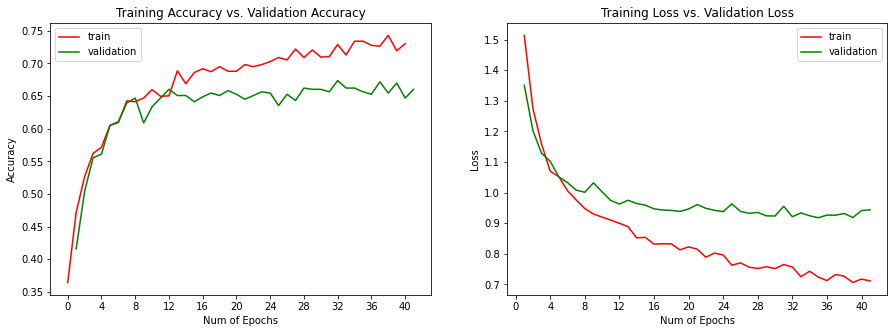

In [28]:
plot_model_history('mobile_net', mobile_net_info.history)

**Membuat Prediksi Untuk Satu Gambar**

In [29]:
img_width, img_height = 224, 224
def predict_one_image(img, model):
  img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
  img = np.reshape(img, (1, img_width, img_height, 3))
  img = img/255.
  pred = model.predict(img)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

cmd 56%


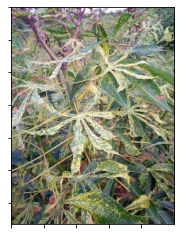

In [30]:
test_img = cv2.imread('train/cgm/train-cgm-50.jpg')
pred, probability = predict_one_image(test_img, mobile_net)
print('%s %d%%' % (categories[pred], round(probability, 2) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid(False)
plt.show()

**Membuat Prediksi Terhadap Beberapa Data Validasi**

In [31]:
def predict_val(val_data, model):
  val_input = np.reshape(val_data, (1, img_width, img_height, 3))
  val_input = val_input/255.
  pred = model.predict(val_input)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

In [32]:
def return_name(label_arr):
  idx = np.where(label_arr == 1)
  return idx[0][0]

Model trained from Mobilenet


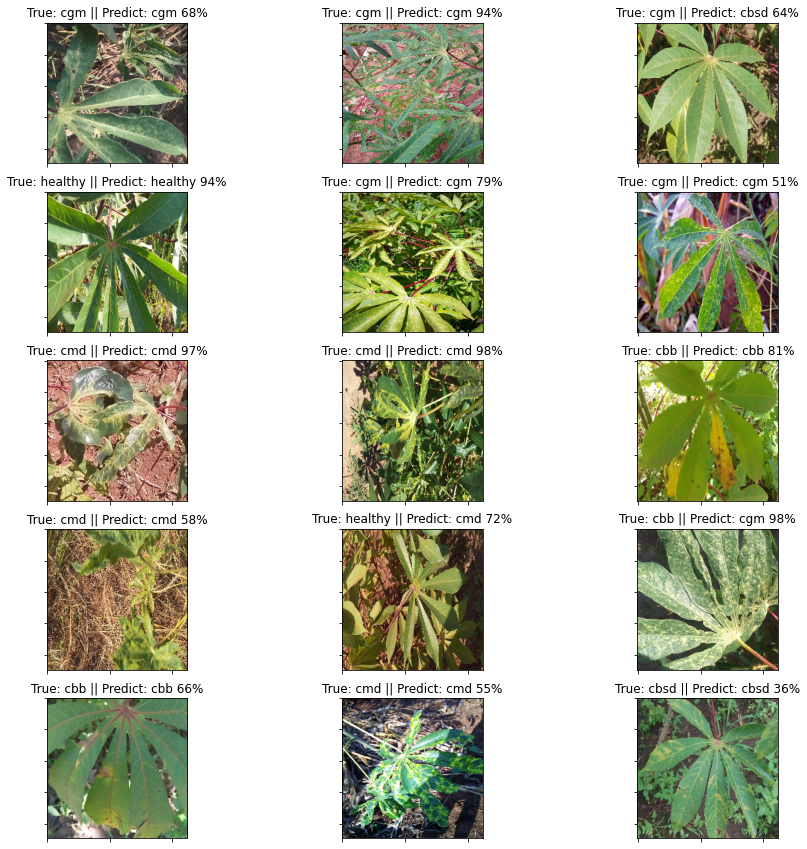

In [35]:
print("Model trained from Mobilenet")
plt.figure(figsize=(15,15))
for i in range(15):
  
  idx = np.random.randint(300)
  
  ax = plt.subplot(5,3,i+1)
  plt.imshow(cvtRGB(val_data.astype('uint8')[idx]))
  category_idx = return_name(val_labels[idx])
  
  pred, prob = predict_val(val_data[idx], mobile_net)
  plt.title('True: %s || Predict: %s %d%%' % (categories[category_idx], categories[pred], round(prob, 2)*100))
  plt.grid(False)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  
plt.show()

**Memuat Nama Gambar Data Tes**

In [36]:
test_base_path = 'test/'
fnames_test = []
for category in categories:
    test_folder = os.path.join(test_base_path, category)
    file_names = os.listdir(test_folder)
    full_path = [os.path.join(test_folder, file_name) for file_name in file_names]
    fnames_test.append(full_path)
print('length for each category:', [len(f) for f in fnames_test])

length for each category: [47, 54, 45, 55, 32]


**Memuat Gambar Data Tes**

In [37]:
test_images = []
for names in fnames_test:
    one_category_images = [cv2.imread(name)/255. for name in names if (cv2.imread(name)) is not None]
    test_images.append(one_category_images)

**Mengubah Ukuran Gambar Data Tes Menjadi 224x224**

In [38]:
# Apply resize to all test images
img_width, img_height = 224, 224
resized_test_images = []
for i,imgs in enumerate(test_images):
    resized_test_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

**Membuat Label Data Tes**

In [40]:
len_test_images = [len(imgs) for imgs in resized_test_images]
print(len_test_images)
print('sum of train images:', np.sum(len_test_images))
test_categories = np.zeros((np.sum(len_test_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        test_categories[:len_test_images[i]] = i
    else:
        test_categories[np.sum(len_test_images[:i]):np.sum(len_test_images[:i+1])] = i

[47, 54, 45, 55, 32]
sum of train images: 233


**Mengkonversi Gambar Data Tes Ke Bentuk Array Numpy**

In [41]:
tmp_test_imgs = []
for imgs in resized_test_images:
    tmp_test_imgs += imgs

test_images = np.array(tmp_test_imgs)

In [42]:
print('Before converting')
print('test data:', test_images.shape)
print('test labels:', test_categories.shape)

test_data = test_images.astype('float32')
test_labels = np_utils.to_categorical(test_categories, len(categories))

print()
print('After converting')
print('train data:', test_data.shape)
print('train labels:', test_labels.shape)

Before converting
test data: (233, 224, 224, 3)
test labels: (233,)

After converting
train data: (233, 224, 224, 3)
train labels: (233, 5)


**Memeriksa Matriks Model Terhadap Data Latih, Data Validasi, dan Data Tes**

In [43]:
print(new_model.metrics_names)
print ('Evaluasi data training')
print(new_model.evaluate(train_generator))
print ('Evaluasi validasi data')
print(new_model.evaluate(val_generator))
print ('Evaluasi data test')
print(new_model.evaluate(x= test_images, y = test_labels)) 

['loss', 'acc']
Evaluasi data training
49/49 [==============================] - 22s 451ms/step - loss: 0.7159 - acc: 0.7449
[0.7158575654029846, 0.7448849081993103]
Evaluasi validasi data
17/17 [==============================] - 1s 81ms/step - loss: 0.9211 - acc: 0.6737
[0.921109139919281, 0.6736640930175781]
Evaluasi data test
8/8 [==============================] - 1s 98ms/step - loss: 1.0090 - acc: 0.6438
[1.0089540481567383, 0.6437768340110779]


**Menampilkan Label Data Tes Sebenarnya dan Label Data Tes Hasil Prediksi**

In [45]:
#Label yang benar
y_true = np.argmax(test_labels,axis=1)
print('label sebenarnya ',y_true)

#Label prediksi
Y_pred = new_model.predict(test_images)
y_pred = np.argmax(Y_pred, axis=1)
print('label hasil prediksi', y_pred)

label sebenarnya  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4]
label hasil prediksi [0 1 0 0 0 2 2 2 0 3 0 1 0 0 2 0 0 4 0 4 0 3 0 0 1 0 0 4 1 0 0 0 0 2 0 0 0
 2 0 2 0 1 1 0 0 4 2 3 1 1 3 1 0 1 1 0 1 0 3 4 1 0 1 1 1 0 1 3 1 1 1 0 1 1
 0 0 1 1 1 1 1 1 2 1 1 1 3 3 1 1 1 1 1 2 2 0 1 1 1 1 1 4 2 2 4 1 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 2 4 2 2 1 1 2 2 2 2 3 2 2 2 1 4 2 4 2 2 1 1 2 0 3 3 2 3
 3 3 1 2 3 3 3 3 3 3 1 2 3 1 3 1 3 3 1 3 1 3 2 0 3 3 1 3 3 0 3 3 3 3 3 1 4
 0 0 4 2 3 3 1 3 2 3 1 3 3 3 3 0 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 1 4 4 4 4 4
 3 4 4 4 4 4 3 4 4 4 3]


**Membuat Confusion Matriks Hasil Prediksi Data Tes**

Normalized confusion matrix
[[0.57 0.13 0.17 0.04 0.09]
 [0.17 0.65 0.06 0.11 0.02]
 [0.02 0.16 0.64 0.07 0.11]
 [0.09 0.18 0.11 0.58 0.04]
 [0.   0.06 0.   0.09 0.84]]


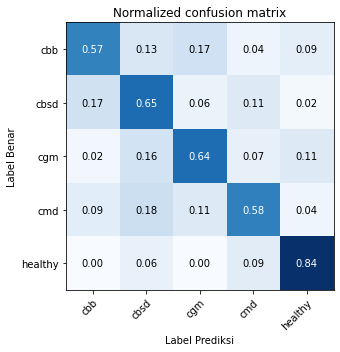

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=categories, normalize=True,
                      title='Normalized confusion matrix')